# [WSI] Ćwiczenie nr 1
Mikołaj Wewiór 318407

In [254]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm


DIMENSIONS = 2


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)


class Function:

    def __init__(self, bounds, dimensions, beta, initial_position):
        self._name = None
        self._bounds = bounds
        self._dimensions = dimensions
        self._beta = beta
        self._current_position = initial_position

    def name(self):
        return self._name

    def d(self):
        return self._dimensions

    def bounds(self):
        return self._bounds

    def position(self):
        return self._current_position

    def set_position(self, new_position):
        self._current_position = new_position

    def beta(self):
        return self._beta

    def set_beta(self, new_beta):
        self._beta = new_beta



    def grad(self, x_vector, i):
        return None


    def update_position(self):
        min_bound = self._bounds[0]
        max_bound = self._bounds[1]
        d = self.d()
        x = copy.deepcopy(self.position())

        for i in range(d):
            upd = self.beta()*self.grad(x, i)
            x[i] = x[i] - upd

            while x[i] > max_bound:
                diff = x[i] - max_bound
                x[i] = min_bound + diff
            while x[i] < min_bound:
                diff = x[i] - min_bound
                x[i] = max_bound + diff

        self.set_position(x)
        return x


In [255]:
class Rastrigin(Function):

    def __init__(self, bounds, dimensions, beta, initial_position):
        super().__init__(bounds, dimensions, beta, initial_position)
        self._name = "Rastrigin"

    def q(self, x_vector):
        d = self._dimensions
        partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)

        cost = 10*d
        for i in range(d) : cost += partial_cost(x_vector[i])

        return cost

    def f(self, x):
        return self.q(x)

    def grad(self, x_vector, i):
        x = x_vector[i]
        gradient = 2*x +20*np.pi*np.sin(np.pi*x)
        return gradient


In [256]:
class Griewank(Function):

    def __init__(self, bounds, dimensions, beta, initial_position):
        super().__init__(bounds, dimensions, beta, initial_position)
        self._name = "Griewank"


    def q(self, x_vector):
        d = self._dimensions

        SUM = 0
        for i in range(d):
            SUM += x_vector[i]**2
        SUM = SUM / 4000

        PI = 1
        for i in range(d):
            PI = PI*np.cos(
                x_vector[i]*np.sqrt(i+1)/(i+1)
            )

        return SUM - PI + 1


    def grad(self, x_vector, i):
        x = x_vector
        PI_rest = 1
        for j in range(self.d()):
            if j != i:
                PI_rest = PI_rest*np.cos(
                    x[j]*np.sqrt(j+1)/(j+1)
                )

        return x[i]/2000 + np.sin(x[i]*np.sqrt(i+1)/(i+1)) * PI_rest*np.sqrt(i+1)/(i+1)


In [257]:
class Test:

    def __init__(self, max_iterations, function, epsilon=None):
        self._max_iterations = max_iterations
        self._last_iteration = max_iterations
        self._function = function
        self._epsilon = epsilon
        self._routes = None


    def max_interations(self):
        return self._max_iterations

    def function(self):
        return self._function

    def initial_position(self):
        return self.function().position()

    def set_routes(self, routes):
        self._routes = routes

    def get_routes(self):
        return self._routes

    def set_last_iteration(self, iteration_id):
        self._last_iteration = iteration_id

    def get_last_iteration(self):
        return self._last_iteration

    def epsilon(self):
        return self._epsilon

    def close_enough(self, last_qs):
        if len(last_qs) < 3:
            return False
        if abs(last_qs[-1] - last_qs[-2]) < self.epsilon():
            return True
        return False

    def break_faster(self, route_q, t):
        if self.epsilon() is not None:
            if self.close_enough(route_q):
                self.set_last_iteration(t)
                return True
        return False

    def do_test(self):
        this_func = self.function()
        route_x = []
        route_y = []
        route_q = []

        for t in range(self.max_interations()):
            x = this_func.position()
            q = this_func.q(x)
            route_x.append(x[0])
            route_y.append(x[1])
            route_q.append(q)
            this_func.update_position()

            if self.break_faster(route_q, t):
                break

        self.set_routes([route_x, route_y, route_q])

        return route_x, route_y, route_q


In [258]:
class Plotter:
    def __init__(self, dimensions, steps, name):
        self._dimensions = dimensions
        self._steps = steps
        self._name = name


    def name(self):
        return self._name

    def d(self):
        return self._dimensions

    def steps(self):
        return self._steps

    def bounds(self):
        if self.name() == "Rastrigin":
            return [-5.12, 5.12]
        else:
            return [-5, 5]

    def q(self, x_vector):
        d = self.d()
        if self.name() == "Rastrigin":
            partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)
            cost = 10*d

            for i in range(d) : cost += partial_cost(x_vector[i])

            return cost

        if self.name() == "Griewank":
            SUM = 0
            for i in range(d):
                SUM += x_vector[i]**2
            SUM = SUM / 4000

            PI = 1
            for i in range(d):
                PI = PI*np.cos(
                    x_vector[i]*np.sqrt(i+1)/(i+1)
                )

            return SUM - PI + 1


    def plot_route(self, route_x, route_y):
        plt.scatter(route_x[1:-1], route_y[1:-1])
        plt.plot(route_x, route_y)
        plt.scatter(route_x[0], route_y[0], color="white")
        plt.scatter(route_x[-1], route_y[-1], color="red")


    def plot(self, route_x=None, route_y=None):
        step = self.steps()
        bounds = self.bounds()
        diff = bounds[1] - bounds[0]
        Z = np.zeros((step+1, step+1))
        for i in range(step+1):
            y = bounds[0] + i*diff/step
            for j in range(step+1):
                x = bounds[0] + j*diff/step
                Z[i][j] = self.q([x, y])

        x = np.linspace(bounds[0], bounds[1], step+1)
        y = np.linspace(bounds[0], bounds[1], step+1)

        X, Y = np.meshgrid(x, y)

        plt.figure()
        plt.ion()
        contour = plt.contourf(X, Y, Z, cmap="plasma", levels=100)

        # Dodanie kolorowej skali
        cbar = plt.colorbar(contour)
        cbar.set_label("Function value")

        plt.grid(True)
        plt.xlabel("X")
        plt.ylabel("Y")

        if not (route_x == None or route_y == None):
            self.plot_route(route_x, route_y)

        plt.show()






In [259]:
heatmap = False

if heatmap:
    STEPS = 400
    RastriginPlot = Plotter(DIMENSIONS, STEPS, "Rastrigin")
    RastriginPlot.plot()

    GriewankPlot = Plotter(DIMENSIONS, STEPS, "Griewank")
    GriewankPlot.plot()


In [269]:
class Experiment:
    def __init__(self, function, iterations: int, step: float, experiment_domain: float, epsilon: float, show: bool):
        self._function = function
        self._iterations = iterations
        self._step = step
        self._domain = experiment_domain
        self._epsilon = epsilon
        self._show = show

    def test_function(self):
        return self._function

    def iterations(self):
        return self._iterations

    def step(self):
        return self._step

    def domain(self):
        return self._domain

    def epsilon(self):
        return self._epsilon

    def show_flag(self):
        return self._show

    def specify_function(self, function, x=None,  beta=None):
        if x != None:
            function.set_position(x)
        if beta != None:
            function.set_beta(beta)

    def plot(self, data, scatter=False):
        X = data[0]
        Y = data[1::]
        plt.figure()
        plt.grid(True)
        for y in Y: plt.plot(X, y)
        if scatter:
            for y in Y: plt.scatter(X, y, c='#ff7f0e')
        plt.show()


    def beta_experiment(self, init_points):
        results = []
        xy_results = []
        for _ in range(len(init_points)+1): xy_results.append([])

        int_range = int(self.domain() / self.step())

        for i in range(int_range+1):

            beta = (i+1)*self.step()
            results.append([])
            xy_results[0].append(beta)

            for t in range(len(init_points)):
                test_func = self.test_function()
                self.specify_function(test_func, init_points[t], beta)

                test = Test(self.iterations(), test_func, self.epsilon())
                route_x, route_y, route_q = test.do_test()
                results[i].append(route_q[-1])
                xy_results[t+1].append(route_q[-1])

        if self.show_flag():
            self.plot(xy_results)


    def initial_position_experiment(self, inits_count, beta):
        xy_results = [[], [], []]
        bound = self.test_function().bounds()[1]

        for _ in range(inits_count):

            # x1 = np.random.uniform(-bound, bound)
            # x2 = np.random.uniform(-bound, bound)
            # x2 = np.random.normal(0, 3.0, 1)
            # x1 = np.random.normal(0, 3.0, 1)
            X = get_truncated_normal(0, 4, -bound, bound)
            x1 = X.rvs()
            x2 = X.rvs()
            position = [x1, x2]
            norm = np.sqrt(x1**2 + x2**2)

            xy_results[0].append(position)
            xy_results[1].append(norm)

            test_func = self.test_function()
            self.specify_function(test_func, position, beta)

            test = Test(self.iterations(), test_func, self.epsilon())
            route_x, route_y, route_q = test.do_test()

            xy_results[2].append(route_q[-1])

        zipped = list(zip(xy_results[1], xy_results[2]))
        dist_q = sorted(zipped, key = lambda x: x[0])
        xs_and_qs = [
            [i for i, j in dist_q],
            [j for i, j in dist_q]
        ]
        if self.show_flag():
            self.plot(xs_and_qs, scatter=True)


        # if self.show_flag():
        #     self.plot(xy_results)



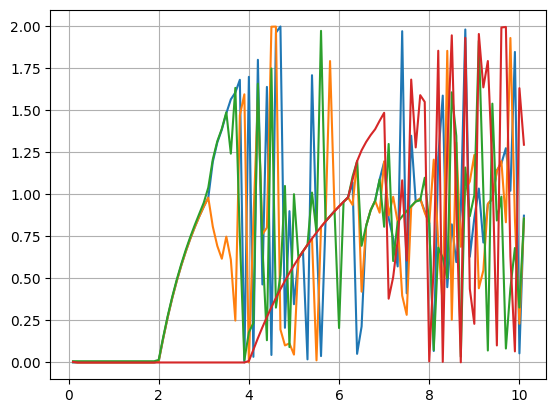

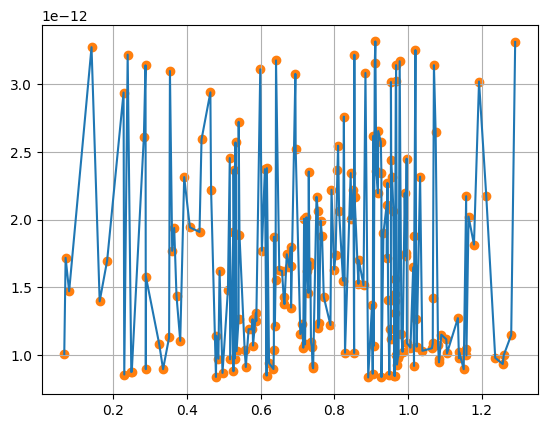

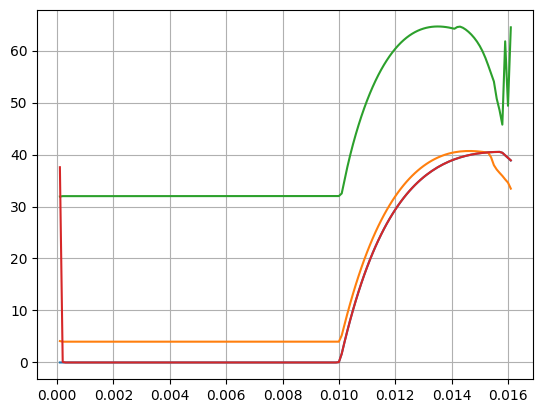

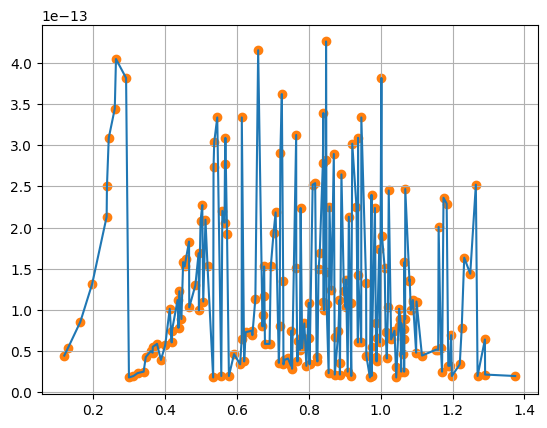

In [270]:
dimensions = DIMENSIONS
COUNT = 200
show_plots = True

# name = "Rastrigin"

# if name == "Griewank":
bounds = [-5.0, 5.0]
iterations = 100

step = 0.1
domain = 10
epsilon = 10**(-11)

beta_init = 1
x_init = [
    [-0.4, 1.0],
    [1.5, 2.2],
    [0.7, -3.7],
    [0.0, 4.0]
]

test_func = Griewank(bounds, DIMENSIONS, beta=None, initial_position=None)
current_experiment = Experiment(test_func, iterations, step, domain, epsilon, show_plots)
current_experiment.beta_experiment(x_init)
current_experiment.initial_position_experiment(COUNT, beta_init)

# if name == "Rastrigin":
bounds = [-5.12, 5.12]
iterations = 200

step = 0.0001
domain = 0.016
epsilon = 10**(-11)

beta_init = 0.004
x_init = [
    [-0.1, 0.2],
    [1.5, 0.57],
    [-4.3, -4.3],
    [-1.0, -1.0]
]


test_func = Rastrigin(bounds, DIMENSIONS, beta=None, initial_position=None)
current_experiment = Experiment(test_func, iterations, step, domain, epsilon, show_plots)
current_experiment.beta_experiment(x_init)
current_experiment.initial_position_experiment(COUNT, beta_init)

In [261]:
# wtedy ta funkcja bedzie musialabyc przerobiona do powyzszej klasy

def experiment(name: str, dimensions: int, bounds: list, x_init: list, iterations: int, step: float, domain: float, epsilon: float, show: bool):

    results = []
    xy_results = []
    for _ in range(len(x_init)+1): xy_results.append([])

    int_range = int(domain / step)

    for i in range(int_range+1):

        beta = (i+1)*step
        results.append([])
        xy_results[0].append(beta)

        for t in range(len(x_init)):
            if name == "Griewank":
                function = Griewank(bounds, dimensions, beta, x_init[t])
            if name == "Rastrigin":
                function = Rastrigin(bounds, dimensions, beta, x_init[t])
            test = Test(iterations, function, epsilon)
            route_x, route_y, route_q = test.do_test()
            results[i].append(route_q[-1])
            xy_results[t+1].append(route_q[-1])

    if show:
        X = xy_results[0]
        Y1 = xy_results[1]
        Y2 = xy_results[2]
        Y3 = xy_results[3]
        Y4 = xy_results[4]

        plt.figure()
        plt.grid(True)
        plt.plot(X, Y1)
        plt.plot(X, Y2)
        plt.plot(X, Y3)
        plt.plot(X, Y4)
        plt.show()

        plt.figure()



# TESTY do sprawka:
&rarr;
Wpływ bety na wartość funkcji:<br>
<!-- &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; -->
widać, że do pewnego punktu charakterystycznego dla danej funkcji jest dobrze a potem są straszne skoki<br><br>
&rarr;
Wpływ odległości punktów inicjalizacji od minimum globalnego:<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<br>

## Griewank

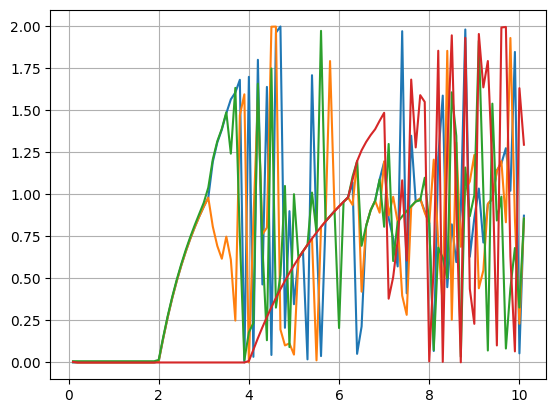

<Figure size 640x480 with 0 Axes>

In [262]:
dimensions = DIMENSIONS
bounds = [-5.0, 5.0]
iterations = 100
step = 0.1
domain = 10
epsilon = 10**(-11)

x_init = [
    [-0.4, 1.0],
    [1.5, 2.2],
    [0.7, -3.7],
    [0.0, 4.0]
]

show_plots = True


experiment(
    "Griewank",
    DIMENSIONS,
    bounds,
    x_init,
    iterations,
    step,
    domain,
    epsilon,
    show_plots
)



## Rastrigin

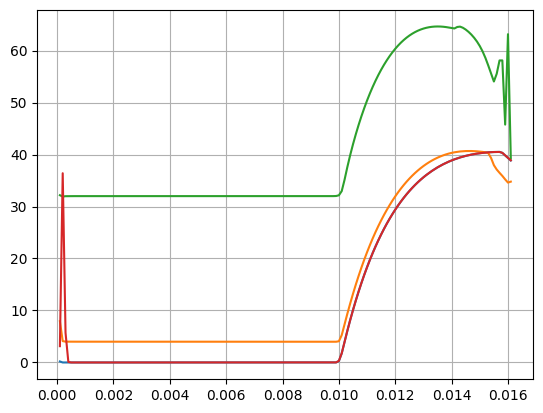

<Figure size 640x480 with 0 Axes>

In [263]:
dimensions = DIMENSIONS
bounds = [-5.12, 5.12]
iterations = 100
step = 0.0001
domain = 0.016


x_init = [
    [-0.1, 0.2],
    [1.5, 0.57],
    [-4.3, -4.3],
    [-1.0, -1.0]
]

show_plots = True

experiment(
    "Rastrigin",
    DIMENSIONS,
    bounds,
    x_init,
    iterations,
    step,
    domain,
    epsilon,
    show_plots
)



# RYSOWANIE

## Griewank

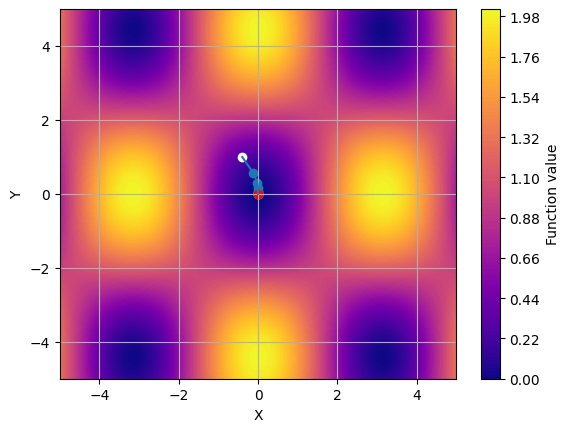

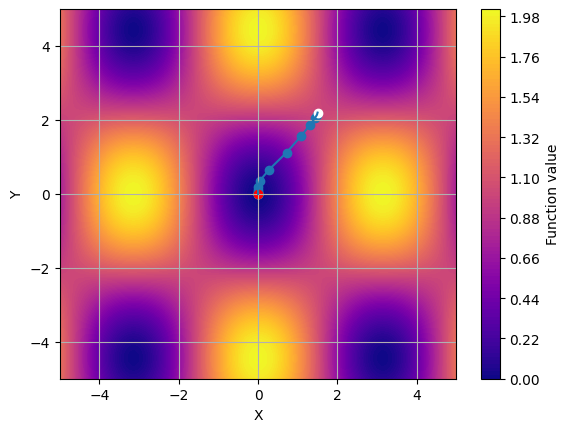

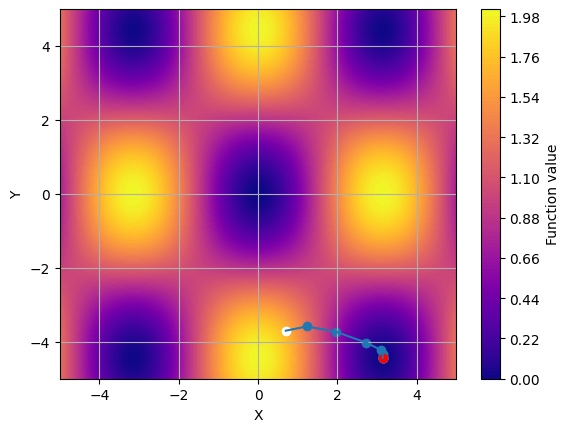

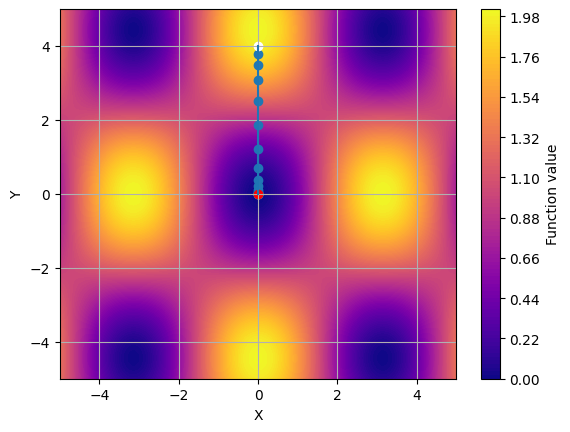

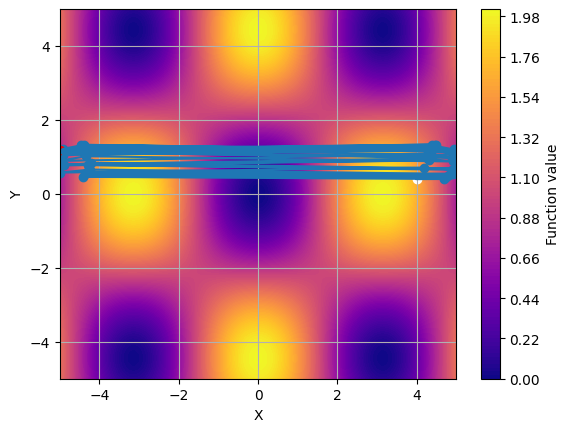

In [264]:
bounds = [-5.0, 5.0]
dimensions = 2
x_init = [
    [-0.4, 1.0],
    [1.5, 2.2],
    [0.7, -3.7],
    [0.0, 4.0],
    [4, 0.4],
]

steps = 400
beta = 0.95

for i in range(len(x_init)):
    function = Griewank(bounds, dimensions, beta, x_init[i])
    test = Test(50, function)
    route_x, route_y, route_q = test.do_test()
    plot = Plotter(dimensions, steps, test.function().name())
    plot.plot(route_x, route_y)
    if i == 2:
        spectator_route = route_q




## Rastring

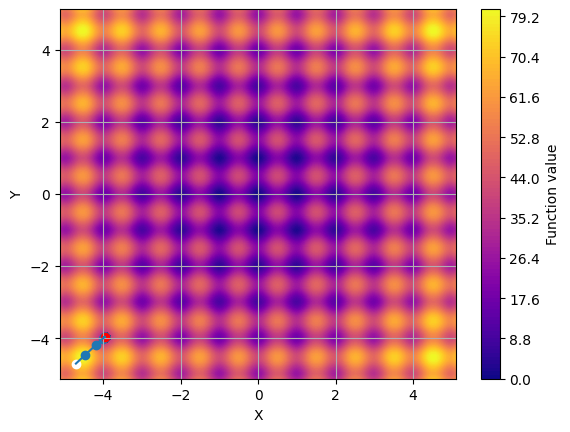

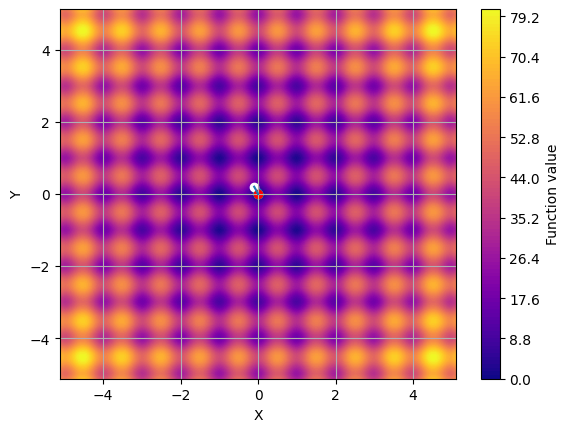

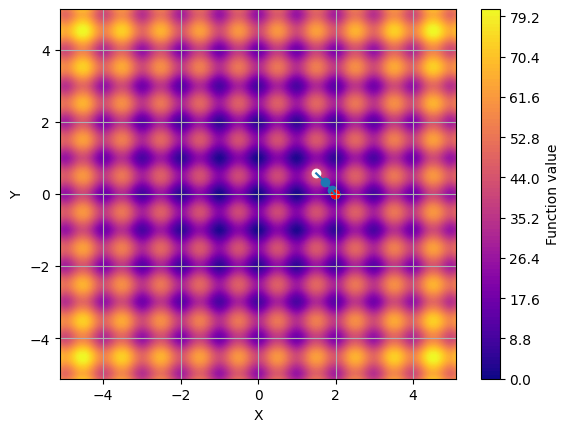

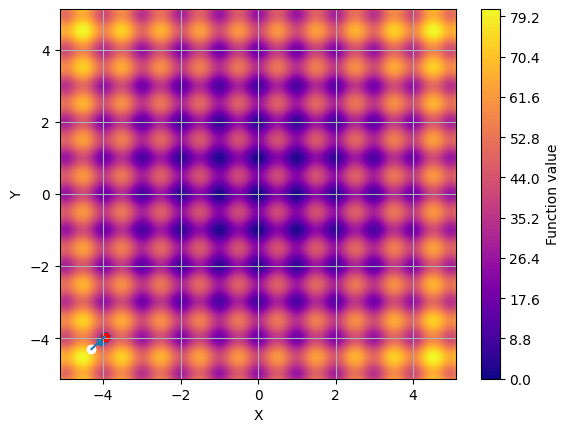

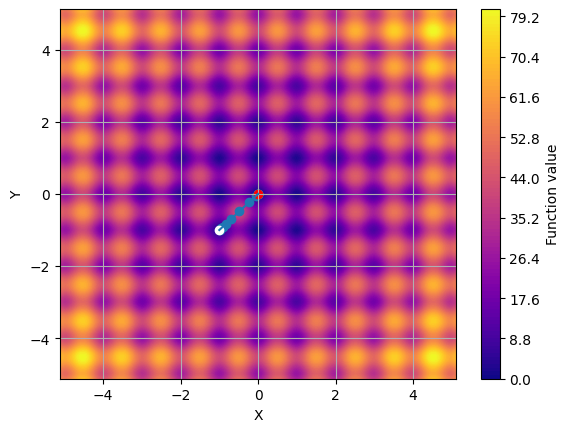

In [265]:
bounds = [-5.12, 5.12]
dimensions = 2
x_init = [
    [-4.7, -4.7],
    [-0.1, 0.2],
    [1.5, 0.57],
    [-4.3, -4.3],
    [-1.0, -1.0]
]

beta = 0.004
steps = 400

for i in range(len(x_init)):
    function = Rastrigin(bounds, dimensions, beta, x_init[i])
    test = Test(100, function, 0.0)
    route_x, route_y, route_q = test.do_test()
    plot = Plotter(dimensions, steps, test.function().name())
    plot.plot(route_x, route_y)



# STARE TESTY
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br><br>
<br>
<br>
<br>
.

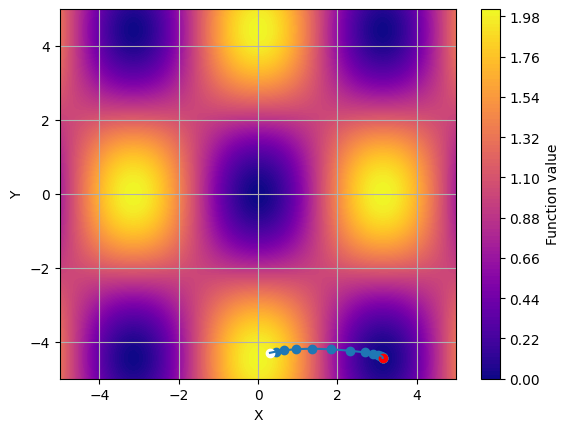

3.140022633889442
-4.438443621624848
0.007396040334299969
[0.3, 0.44693159427438617, 0.6612466284564826, 0.964693506343766, 1.3693402556684442, 1.8508753924600336, 2.324052726553742, 2.6845693712967718, 2.9031930736853466, 3.0201205224108505, 3.079827211525857, 3.1098832781714485, 3.1249466669179355, 3.1324845547175144, 3.1362542691014053, 3.138138969702322, 3.1390811039231723, 3.139552027100515, 3.1397874079652075, 3.1399050565252544, 3.1399638601547712, 3.1399932522480074, 3.1400079439861432, 3.1400152881354257, 3.140018959676542, 3.1400207954220396, 3.1400217134607353, 3.1400221726949913, 3.140022402517324, 3.1400225176036884, 3.1400225752884965, 3.14002260424199, 3.140022618804348, 3.140022626150801, 3.1400226298734686, 3.1400226317720983, 3.140022632749476, 3.140022633259248, 3.1400226335299584, 3.1400226336771837, 3.140022633759698, 3.1400226338076296, 3.1400226338365993, 3.140022633854835, 3.140022633866765, 3.140022633874838, 3.140022633880455, 3.140022633884448, 3.140022633887

In [266]:
# x_init = [-0.6, 2.132]
# x_init = [-4, -2]
# x_init = [3.8, -3]
# x_init = [2, -3.3]
x_init = [0.3, -4.3]
rast = Rastrigin([-5.12, 5.12], 2, 0.005, x_init)
gierek = Griewank([-5.0, 5.0], 2, 0.5, x_init)

test1 = Test(50, gierek)
route_x, route_y, route_q = test1.do_test()

one = Plotter(2, 400, test1.function().name())
one.plot(route_x, route_y)
# one.plot_route(route_x, route_y)

print(route_x[-1])
print(route_y[-1])
print(route_q[-1])

print(route_x)
print(route_y)
print(route_q)

# TESTOWE

dla mnie, nie do sprawozdania :(

In [267]:
def q(d, x_vector):
    partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)
    cost = 2*d
    for i in range(d) : cost += partial_cost(x_vector[i])
    return cost


def test(d, x1, x2):

    x_vector = [x1, x2]

    # print(10*d)
    # partial_cost = lambda x: x**2
    print(1)
    partial_cost = lambda x: x**2/4000
    bleh = partial_cost(x1)
    print(bleh)
    blah = partial_cost(x2)
    print(blah)

    # cost = 10*d
    # for i in range(d) : cost += partial_cost(x_vector[i])
    cost = 1
    for i in range(d) : cost += partial_cost(x_vector[i])

    return cost


# test(2, 4000, 8000)

[-4, -4.058009288662987, -4.0596254239865575, -4.001288071407906, -3.8862227996966774, -3.728571685273543, -3.5568181406211936, -3.4051679434462434, -3.2944224678014384, -3.2245634637550395, -3.184562518112286, -3.162956679662112, -3.151674977195941, -3.1458972814648463, -3.1429710303911147, -3.1414984028035917, -3.1407600626911103, -3.1403907010597423, -3.14020618344671, -3.1401140948543733, -3.140068169998547, -3.140045282759004, -3.140033884773586, -3.1400282132604436, -3.1400253941533816, -3.140023994829255, -3.140023301569477, -3.1400229590316235, -3.140022790436123, -3.1400227079230962, -3.1400226678823766, -3.1400226487054383, -3.1400226397113595, -3.14002263563879, -3.1400226339089348, -3.1400226332671526, -3.140022633109876, -3.1400226331518457, -3.1400226332621024, -3.1400226333835164, -3.1400226334935595, -3.1400226335853683, -3.1400226336587402, -3.1400226337159562, -3.140022633759921, -3.1400226337933974, -3.1400226338187416, -3.14002263383786, -3.1400226338522486, -3.1400

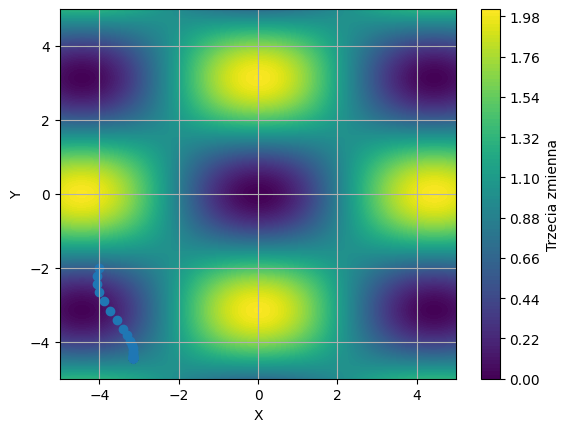

In [268]:
def q(d, x_vector):

    SUM = 0
    for i in range(d):
        SUM += x_vector[i]**2/4000

    PI = 1
    for i in range(d):
        PI = PI*np.cos(x_vector[i]/np.sqrt(i+1))

    return SUM - PI + 1

max_boud = 5
min_bound = -5
diff = max_boud-min_bound
step = 200

bounds = [-5, 5]

# meshgrid = []
d = 2
Z = np.zeros((201, 201))
for i in range(step+1):
    # meshgrid.append([])
    x = min_bound + i*diff/step
    for j in range(step+1):
        y = min_bound + j*diff/step
        # meshgrid[i].append(q(d, [x, y]))
        Z[i][j] = q(d, [x, y])

x = np.linspace(-5, 5, 201)
y = np.linspace(-5, 5, 201)

X, Y = np.meshgrid(x, y)


# plt.pcolor(X, Y, Z)
# plt.show()
plt.ion()
fig = plt.figure()
contour = plt.contourf(X, Y, Z, cmap="viridis", levels=100)

# Dodanie kolorowej skali
cbar = plt.colorbar(contour)
cbar.set_label("Trzecia zmienna")

plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")



x_init = [-4, -2]
racik = Rastrigin([-5.12, 5.12], 2, 0.01, x_init)
gierek = Griewank([-5, 5], 2, 0.5, x_init)

route = [[gierek.position(), gierek.q(x_init)]]
route_x = [gierek.position()[0]]
route_y = [gierek.position()[1]]
for t in range(800):
    gierek.update_position()
    route.append([gierek.position(), gierek.q(gierek.position())])
    route_x.append(gierek.position()[0])
    route_y.append(gierek.position()[1])

plt.scatter(route_x, route_y)

print(route_x)
print(route_y)

# Polecenie

Eksperymenty powinny zawierać między innymi: testy różnych wartości parametrów uczenia (BETA, patrz slajdy z wykładu), oraz różne punkty inicjalizacji (blisko optimum, daleko od optimum). W czasie zajęć proszę pokazać zbieżność dla funkcji: <br>
f(x) = SUM_i^d (x_1)^2